# Early detection of Alzheimer's disease using blood gene expression data
## Design Project
by J. Hariharan and Dr. R. Jothi

In [28]:
import pandas as pd
import numpy as np
import GEOparse
import os
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Parsing GSE63060 and GSE63061 dataset

In [29]:
dataset_directory = "../DataSets/"
parsed_data_file_suffix = "_parsed_data.csv"

In [30]:
gses = {}

gses["GSE63060"] = GEOparse.get_GEO(filepath="../DataSets/GSE63060_family.soft.gz")
gses["GSE63061"] = GEOparse.get_GEO(filepath="../DataSets/GSE63061_family.soft.gz")

len(gses)

02-Mar-2023 18:34:28 INFO GEOparse - Parsing ../DataSets/GSE63060_family.soft.gz: 
02-Mar-2023 18:34:28 DEBUG GEOparse - DATABASE: GeoMiame
02-Mar-2023 18:34:28 DEBUG GEOparse - SERIES: GSE63060
02-Mar-2023 18:34:28 DEBUG GEOparse - PLATFORM: GPL6947
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539080
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539081
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539082
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539083
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539084
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539085
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539086
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539087
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539088
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539089
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539090
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539091
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539092
02-Mar-2

2

In [31]:
# 1. Finding Gene symbols for the ID_REF values
# 2. Group the rows based on Gene Symbol values
# 3. replace the groups with a single row with Gene Symbol of the group and the Median of the gene expression value

for datasetName in gses:
    gse = gses[datasetName]
    gpl_lookup = []

    for gpl_name, gpl in gse.gpls.items():
        gpl_lookup = gpl.table.filter(["ID", "ILMN_Gene"]).set_index("ID")[
            "ILMN_Gene"].to_dict()

    column_names = ["sample_id", "status", "ethinicity",
                    "age", "gender", "included_in_case_study", "tissue"]
    values = []
    for gsm_name, gsm in gse.gsms.items():
        row = {}
        row[column_names[0]] = gsm_name

        for characteristic in gsm.metadata["characteristics_ch1"]:
            chsplit = characteristic.split(": ")
            row[chsplit[0]] = chsplit[1]

        tempdf = gsm.table.copy(deep=True)
        tempdf["ID_REF"] = tempdf["ID_REF"].apply(
            lambda id_ref: gpl_lookup[id_ref])
        tempdf = tempdf["VALUE"].groupby(tempdf["ID_REF"])
        for key, group in tempdf:
            row[key] = group.median()

        values.append(row)

    dataset = pd.DataFrame.from_dict(values)
    dataset.to_csv(dataset_directory + datasetName + parsed_data_file_suffix, index=False)

### Integrating the parsed datasets

In [168]:
datasets = []
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Loading the parsed data
file_Id = 0
for file in os.listdir(dataset_directory):
    if file.endswith("_parsed_data.csv"):
        file_path = os.path.join(dataset_directory, file)
        dataset = pd.read_csv(file_path, index_col="sample_id")
        x_scaled_values = min_max_scaler.fit_transform(dataset.iloc[:, 6:].values)
        dataset.iloc[:, 6:] = x_scaled_values        
        datasets.append(dataset)


In [169]:
# extract only common columns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

common_columns = datasets[0]
for i in range(1, len(datasets)):
    common_columns = intersection(common_columns, datasets[i])

print("No of Common Columns :", end=" ")
print(len(common_columns))

for i in range(len(datasets)):
    datasets[i] = datasets[i][common_columns]
    print(datasets[i].shape)

master_dataset = pd.concat(datasets)

print(master_dataset.shape)

# Save master dataset
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

No of Common Columns : 12459
(388, 12459)
(329, 12459)
(431, 12459)
(1148, 12459)


,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Min-Max Normalisation of the Master Data

In [170]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled_values = min_max_scaler.fit_transform(master_dataset.iloc[:, 6:].values)
master_dataset.iloc[:, 6:] = x_scaled_values
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Loading Processed Dataset

In [37]:
### Loading Processed data
master_dataset = pd.read_csv("../DataSets/master_dataset.csv", index_col="sample_id")
#master_dataset = master_dataset[master_dataset["status"] != "MCI"]
master_dataset.shape


(717, 19465)

In [171]:
master_dataset = master_dataset[(master_dataset["status"] == "AD") | (master_dataset["status"] == "CTL")]
set(master_dataset["status"])

{'AD', 'CTL'}

In [182]:
K = 40
gene_index = []
selected_genes = []

chi2 = feature_selection.SelectKBest(feature_selection.chi2, k=K)
chi2.fit_transform(master_dataset.iloc[:, 6:].values, master_dataset.iloc[:, 0])
chi2_support = chi2.get_support()

for i in range(len(chi2_support)):
    if(chi2_support[i] == True):
        gene_index.append(i)

index = 0
for i in gene_index:
    selected_genes.append(master_dataset.columns[i+6])
    print(master_dataset.columns[i+6])
    index += 1

CCND1
CEP70
CMBL
CSF2RB
CYB5B
DMD
DNAJC8
FCGR3A
GABRB2
GAGE7
GKN2
KLF1
LAMB1
LSS
MAP7D3
MAZ
MGAT2
MRPL33
MRPS21
NBPF10
OPN1SW
PFKFB2
PTPRK
RBBP7
RIOK1
RMND5B
ROR1
RPL36AL
RPS27A
SLC25A15
TDRD1
TICAM2
TNFRSF10D
TOR1AIP2
TPO
TXNDC5
USP13
XYLB
ZBTB16
ZNF16


In [183]:
X = master_dataset[selected_genes].values
Y = master_dataset["status"].values

print(X)
print(Y)

[[0.46270387 0.38131563 0.19887672 ... 0.24854686 0.19885151 0.62694394]
 [0.457699   0.32569334 0.33114595 ... 0.27834891 0.         0.83476809]
 [0.42700799 0.41097207 0.19256631 ... 0.50510071 0.27935833 0.496244  ]
 ...
 [0.1464315  0.1350211  0.37533753 ... 0.17188638 0.42447825 0.25035088]
 [0.11361772 0.06238698 0.89738974 ... 0.48470503 0.66501592 0.17315789]
 [0.22723544 0.08107294 0.47524752 ... 0.29461034 0.55925009 0.21929825]]
['CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL' 'CTL'
 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD'
 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' '

In [184]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, shuffle=True)



In [185]:
svm_model = SVC(kernel="linear")
svm_model.fit(x_train, y_train)

train_score = svm_model.score(x_train, y_train)
print(train_score)

test_score = svm_model.score(x_test, y_test)
print(test_score)

0.8860569715142429
0.8286713286713286


In [176]:
#Label encoding
def LabelEncoding(Y): 
    le = preprocessing.LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_test = LabelEncoding(y_test)
y_train = LabelEncoding(y_train)

y_test = tf.one_hot(y_test, depth=2)
y_train = tf.one_hot(y_train, depth=2)

print(y_test)

tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]

In [177]:
dnn_model = tf.keras.models.Sequential()
dnn_model.add(tf.keras.layers.Dense(6, activation="relu", input_shape=(K,)))
dnn_model.add(tf.keras.layers.Dense(4, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(4, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(2, activation="softmax"))

dnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
dnn_results = dnn_model.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_test, y_test))

Epoch 1/100
 1/34 [..............................] - ETA: 13s - loss: 0.7863 - accuracy: 0.3000

2023-03-02 22:24:57.252761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7421

2023-03-02 22:24:58.079327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 1s 27ms/step - loss: 0.6227 - accuracy: 0.7421 - val_loss: 0.5690 - val_accuracy: 0.7168
Epoch 2/100
34/34 [==============================] - 1s 18ms/step - loss: 0.4917 - accuracy: 0.7646 - val_loss: 0.5074 - val_accuracy: 0.7168
Epoch 3/100
34/34 [==============================] - 1s 19ms/step - loss: 0.4261 - accuracy: 0.7691 - val_loss: 0.4567 - val_accuracy: 0.7483
Epoch 4/100
34/34 [==============================] - 1s 19ms/step - loss: 0.3815 - accuracy: 0.8051 - val_loss: 0.4204 - val_accuracy: 0.7587
Epoch 5/100
34/34 [==============================] - 1s 18ms/step - loss: 0.3510 - accuracy: 0.8306 - val_loss: 0.4058 - val_accuracy: 0.7902
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.3334 - accuracy: 0.8336 - val_loss: 0.4111 - val_accuracy: 0.7517
Epoch 7/100
34/34 [==============================] - 1s 18ms/step - loss: 0.3223 - accuracy: 0.8441 - val_loss: 0.3933 - val_accuracy: 0.7727
Epoch 8/100
34/34 

In [180]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(K, K)))
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu"))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(100, activation="relu"))
cnn_model.add(tf.keras.layers.Dense(2, activation="softmax"))

cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn_results = dnn_model.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_test, y_test))

Epoch 1/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.9485 - val_accuracy: 0.7972
Epoch 2/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.9087 - val_accuracy: 0.7902
Epoch 3/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9346 - val_accuracy: 0.8007
Epoch 4/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.9415 - val_accuracy: 0.7937
Epoch 5/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.9449 - val_accuracy: 0.7972
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9552 - val_accuracy: 0.7937
Epoch 7/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.9644 - val_accuracy: 0.8007
Epoch 

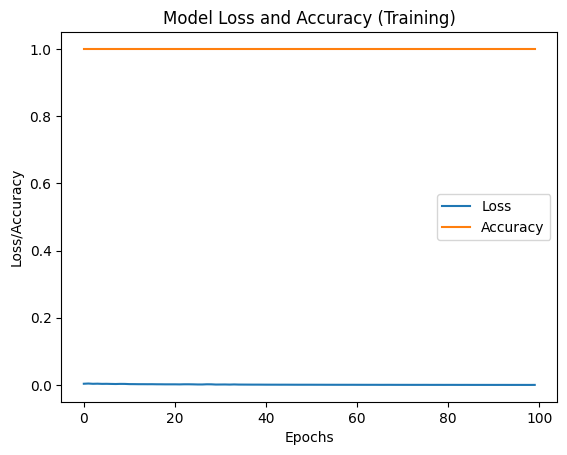

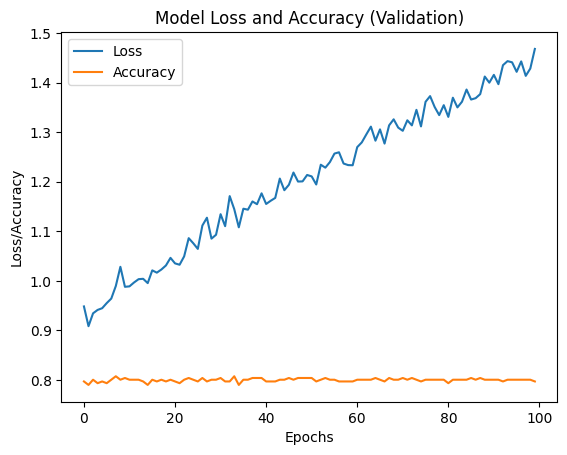

In [181]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(cnn_results.history["loss"])
plt.plot(cnn_results.history["accuracy"])
plt.title("Model Loss and Accuracy (Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()

#Plotting the testing results
import matplotlib.pyplot as plt
plt.plot(cnn_results.history["val_loss"])
plt.plot(cnn_results.history["val_accuracy"])
plt.title("Model Loss and Accuracy (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()